# Meep Adjoint Solver - Introduction

This tutorial serves as a basic introduction to MEEP's adjoint solver. The adjoint solver provides a simple and flexible interface to calculating "sensitivities" or gradients of user specified objective functions with respect to **any number** of design variables -- **all with the cost of just two simulations.**

Practical electromagnetic design problems are often constrained by complicated design requirements that aren't easily satisfied with physical intuition. We often formulate our problem as functions of Fourier transformed fields, (e.g. S-parameters, Poynting Fluxes, mode overlap coefficients, etc.). We can "inverse design" a structure that maximizes (or minimizes) this cost function with various optimization algorithms. The adjoint method provides an extremely cheap gradient, accelerating many out of the box optimization algorithms.

In this tutorial, we'll demonstrate how you can quickly begin leveraging this interface. As a toy example, we'll examine a 2D integrated photonic waveguide bend. We'll code up a cost function that will tell our optimizer to maximize power transport around the bend. We'll discretize the bend into several individual pixels and calculate the gradient of this cost function w.r.t. all these pixels. Finally, we'll compare our gradients with finite difference approximates, which are much more expensive to calculate. Hopefully by the end of the tutorial, you appreciate the simplicity and flexibility this particular package offers. 

First, we'll import `meep` and `autograd`, a widely used automatic differentiation package. `autograd` wraps around `numpy` and allows us to quickly differentiate functions composed of standard `numpy` routines. This will be especially useful when we want to formulate our objective function.

In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt
mp.quiet(quietval=True)

Using MPI version 3.1, 1 processes


Next, we'll begin to specify the domain of our waveguide bend simulation, just as we would with any other simulation.

In [2]:
resolution = 10

Sx = 6
Sy = 5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(1.0)]

We'll then define our sources. We'll use a narrowband Gaussian pulse, even though our objective function will only operate over a single wavelength (for this example). While we could use the CW solver, it's often faster (and more dependable) to use the timestepping routines and a narrowband pulse.

In [3]:
fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-1,0,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center)]

Now, we'll define our waveguide geometry and "design region". The design region takes a 10x10 grid of randomly generated design variables and maps them to a point within the specified volume. Since meep operates under the "illusion of continuitiy", it's important we provide an interpolator to perform this mapping.

In this case, we'll use a builtin bilinear interpolator to take care of this for us. You can use whatever interpolation function you want, provided it can return either a medium or permittivity (as described in the manual) and you can calculate the gradient of the interpolator with respect to the inputs (often just a matrix multiplication). The built-in interpolator takes care of all of this for us.

In [4]:
seed = 24
np.random.seed(seed)

Nx = 10
Ny = 10

design_region = mp.Volume(center=mp.Vector3(), size=mp.Vector3(1, 1, 0))
rho_vector = 11*np.random.rand(Nx*Ny) + 1
basis = mpa.BilinearInterpolationBasis(volume=design_region,Nx=Nx,Ny=Ny,rho_vector=rho_vector)

geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=mp.Medium(index=3.45), size=mp.Vector3(Sx/2, 0.5, 0)), # horizontal waveguide
    mp.Block(center=mp.Vector3(y=Sy/4), material=mp.Medium(index=3.45), size=mp.Vector3(0.5, Sy/2, 0)),  # vertical waveguide
    mp.Block(center=design_region.center, size=design_region.size, epsilon_func=basis.func()) # design region
]

We can now formulate or simulation object

In [5]:
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    eps_averaging=False,
                    resolution=resolution)

and visualize our simulation domain to ensure everything looks correct.

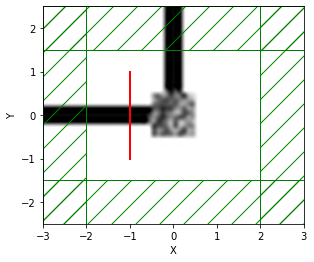

In [6]:
sim.plot2D()
plt.show()

Next, we'll start defining our objective function. Objective functions must be composed of "field functions" that transform the recorded fields. Right now, only the Eigenmode Decomposition monitors are readily accessible from the adjoint API. That being said, it is easy to extend the API to other field functions, like Poynting fluxes.

In our case, we just want to maximize the power in the fundamental mode at the top of the waveguide bend. We'll define a new object that specifies these details. We'll also create a list of our objective "quantities" (just one in our case).

In [7]:
TE0 = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(0,1,0),size=mp.Vector3(x=2)),mode=1)
ob_list = [TE0]

Our objective function will take the magnitude squared of our predefined objective quantity. We'll define the function as a normal python function. We'll use dummy parameters that map sequentially to the list of objective quantities we defined above. We'll also use autograd's version of numpy so that the adjoint solver can easily differentiate our objective function with respect to each of these quantities. 

In [8]:
def J(alpha):
    return npa.abs(alpha) ** 2

We can now define an `OptimizationProblem` using our simulation object, objective function, and objective quantities (or arguments). We'll also tell the solver to examine the `Ez` component of the Fourier transformed fields. The solver will stop the simulation after these components have stopped changing by a certain relative threshold (default is 1e-6).

In [9]:
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_function=J,
    objective_arguments=ob_list,
    basis=[basis],
    fcen=fcen,
    decay_fields=[mp.Ez]
)

Next, we can visualize our final simulation domain with any extra monitors as defined by our objective function. This `plot2D` function is just like `Simulation`'s `plot2D`, only it takes an additional first argument. We'll set it to `True` to tell the solver to initialize the solver and clear any stored fields.

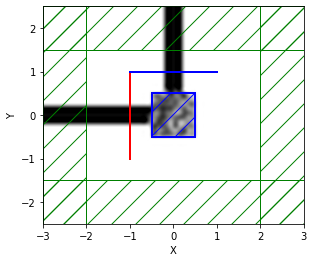

In [10]:
opt.plot2D(True)
plt.show()

We see an expected monitor on the top of the waveguide, but we also see an additional monitor spanning our design region. This monitor records the Fourier transformed fields needed to calulcate the gradient.

Since everything looks good, we can go now calculate the gradient and the cost function evaluation. We do so by calling our solver object directly. The object first returns the objective function evaluation `f0`, a list of numpy arrays, `dJ_deps` for the gradient, and the "design grid", `dg`. 

In [11]:
f0, dJ_deps, dg = opt()

Starting forward run...
Starting adjoint run...
Calculating gradient...


Since the user can specify multiple design regions, the solver always output a list of gradients. The design grid provides the points in space that map to these gradients.

It's very important to note that these gradients are with respect to the permittivity, not the actual design parameters. In our case, we need to use the chain rule to back out the gradient with respect to the actual design parameters.

Our interpolation basis makes this very easy. We simply provide the gradient and corresponding design grid to its vector-jacobian product function, `get_basis_vjp`.

In [12]:
g_adjoint = basis.get_basis_vjp(dJ_deps[0],dg[0])

We now have a gradient with respect to our design parameters. To verify the accuracy of our method, we'll perform a finite difference approximation. 

Luckily, our solver has a built finite difference method (`calculate_fd_gradient`). Since the finite difference approximates require several expensive simulations, we'll only estimate 20 of them (randomly sampled by our function).

In [13]:
db = 1e-3
choose = 20
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)

We can compare the results by fitting a line to the two gradients

In [14]:
(m, b) = np.polyfit(g_discrete, g_adjoint, 1)

and subsequently plot the results

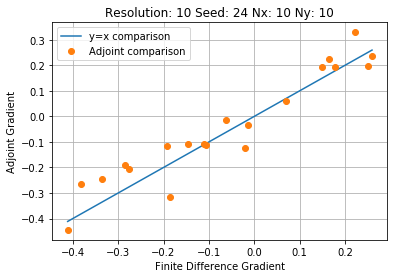

In [15]:
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

plt.figure()
plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
plt.plot(g_discrete[idx],g_adjoint[idx],'o',label='Adjoint comparison')
plt.xlabel('Finite Difference Gradient')
plt.ylabel('Adjoint Gradient')
plt.title('Resolution: {} Seed: {} Nx: {} Ny: {}'.format(resolution,seed,Nx,Ny))
plt.legend()
plt.grid(True)
plt.show()

We notice that the gradients certainly have a positive correlation, but aren't perfectly matched. This is due to a number of factors. First, MEEP uses an internal interpolation scheme between various points on the Yee grid. Second, the adjoint method for the FDTD formalism assumes each pixel is very small.

We can see that the results improve as resolution increases.

In [16]:
resolution = 20
opt.sim.resolution = resolution
f0, dJ_deps, dg = opt()
g_adjoint = basis.get_basis_vjp(dJ_deps[0],dg[0])
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)
(m, b) = np.polyfit(g_discrete, g_adjoint, 1)

Starting forward run...
Starting adjoint run...
Calculating gradient...


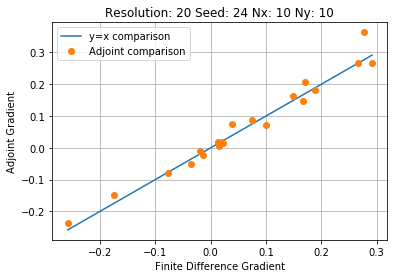

In [17]:
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

plt.figure()
plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
plt.plot(g_discrete[idx],g_adjoint[idx],'o',label='Adjoint comparison')
plt.xlabel('Finite Difference Gradient')
plt.ylabel('Adjoint Gradient')
plt.title('Resolution: {} Seed: {} Nx: {} Ny: {}'.format(resolution,seed,Nx,Ny))
plt.legend()
plt.grid(True)
plt.show()

We'll increase it one more time and see an improvement:

In [18]:
resolution = 50
opt.sim.resolution = resolution
f0, dJ_deps, dg = opt()
g_adjoint = basis.get_basis_vjp(dJ_deps[0],dg[0])
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)
(m, b) = np.polyfit(g_discrete, g_adjoint, 1)

Starting forward run...
Starting adjoint run...
Calculating gradient...


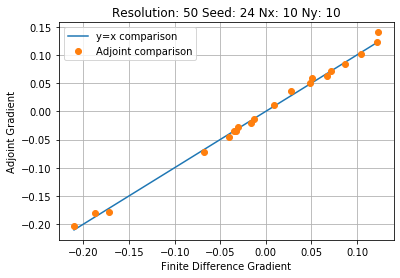

In [19]:
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

plt.figure()
plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
plt.plot(g_discrete[idx],g_adjoint[idx],'o',label='Adjoint comparison')
plt.xlabel('Finite Difference Gradient')
plt.ylabel('Adjoint Gradient')
plt.title('Resolution: {} Seed: {} Nx: {} Ny: {}'.format(resolution,seed,Nx,Ny))
plt.legend()
plt.grid(True)
plt.show()